<a href="https://colab.research.google.com/github/gmukku/ML-Interpretability-Responsible-AI/blob/main/10_735_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [ ]:
# Load the data set
data = fetch_openml(name='titanic', version=1)
# Separate the features and target variable
titanic_X = data.data
titanic_X = titanic_X.drop(columns=[
"name",
"cabin",
"embarked",
"home.dest",
"ticket",
"boat"
])
titanic_X["sex"] = titanic_X["sex"].transform(lambda x: 1 if x == "female" else 0)
for col in titanic_X.columns:
    titanic_X[col] = titanic_X[col].transform(lambda x: -1 if pd.isna(x) else x)
    titanic_X[col] = pd.to_numeric(titanic_X[col])
titanic_y = data.target
titanic_y = pd.to_numeric(titanic_y)

In [ ]:
titanic_X

,pclass,sex,age,sibsp,parch,fare,body
0,1,1,29.0000,0,0,211.3375,-1.0
1,1,0,0.9167,1,2,151.5500,-1.0
2,1,1,2.0000,1,2,151.5500,-1.0
3,1,0,30.0000,1,2,151.5500,135.0
4,1,1,25.0000,1,2,151.5500,-1.0
...,...,...,...,...,...,...,...
1304,3,1,14.5000,1,0,14.4542,328.0
1305,3,1,-1.0000,1,0,14.4542,-1.0
1306,3,0,26.5000,0,0,7.2250,304.0
1307,3,0,27.0000,0,0,7.2250,-1.0


In [ ]:
data.data

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


# Diversity Check

In [ ]:
# Check unique values in categorical columns and range in numerical columns
diversity_summary = pd.DataFrame({
    "Unique Values": titanic_X.nunique(),
    "Min": titanic_X.min(),
    "Max": titanic_X.max(),
    "Missing Values %": (titanic_X == -1).mean() * 100
})
print(diversity_summary)

        Unique Values  Min       Max  Missing Values %
pclass              3  1.0    3.0000          0.000000
sex                 2  0.0    1.0000          0.000000
age                99 -1.0   80.0000         20.091673
sibsp               7  0.0    8.0000          0.000000
parch               8  0.0    9.0000          0.000000
fare              282 -1.0  512.3292          0.076394
body              122 -1.0  328.0000         90.756303


In [ ]:
from sklearn.model_selection import train_test_split
titanic_X_train, titanic_X_test, titanic_y_train, titanic_y_test = train_test_split(titanic_X, titanic_y, test_size=0.3, random_state=42)

# Randomized Search for Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

param_dist = {
    'C': loguniform(0.001, 10),
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga'],
    'tol': loguniform(1e-5, 1e-2),
    'max_iter': [100, 200, 300, 500]
}

log_reg = LogisticRegression(random_state=42)

# Perform Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    log_reg, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
random_search.fit(titanic_X_train, titanic_y_train)

best_log_reg_model = random_search.best_estimator_

train_predictions = best_log_reg_model.predict(titanic_X_train)
test_predictions = best_log_reg_model.predict(titanic_X_test)

train_accuracy = accuracy_score(titanic_y_train, train_predictions)
test_accuracy = accuracy_score(titanic_y_test, test_predictions)

print("Best Hyperparameters for Logistic Regression:")
print(random_search.best_params_)
print("\nTraining Performance:")
print(f"Accuracy: {train_accuracy}")
print("Confusion Matrix:\n", confusion_matrix(titanic_y_train, train_predictions))
print("Classification Report:\n", classification_report(titanic_y_train, train_predictions))

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print("Confusion Matrix:\n", confusion_matrix(titanic_y_test, test_predictions))
print("Classification Report:\n", classification_report(titanic_y_test, test_predictions))

Best Hyperparameters for Logistic Regression:
{'C': 0.3446715036561302, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0002940074130903306}

Training Performance:
Accuracy: 0.7936681222707423
Confusion Matrix:
 [[504  81]
 [108 223]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       585
           1       0.73      0.67      0.70       331

    accuracy                           0.79       916
   macro avg       0.78      0.77      0.77       916
weighted avg       0.79      0.79      0.79       916


Test Performance:
Accuracy: 0.7938931297709924
Confusion Matrix:
 [[199  25]
 [ 56 113]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       224
           1       0.82      0.67      0.74       169

    accuracy                           0.79       393
   macro avg       0.80      0.78      0.78       393
weighted a

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
135 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 300),             # Number of trees in the forest
    'max_depth': [None] + list(range(10, 40)),    # Maximum depth of trees
    'min_samples_split': randint(2, 20),          # Minimum number of samples to split a node
    'min_samples_leaf': randint(1, 10),           # Minimum number of samples at a leaf node
    'bootstrap': [True, False]                    # Whether to use bootstrap samples
}

rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
random_search.fit(titanic_X_train, titanic_y_train)

best_rf_model = random_search.best_estimator_

train_predictions = best_rf_model.predict(titanic_X_train)
test_predictions = best_rf_model.predict(titanic_X_test)

train_accuracy = accuracy_score(titanic_y_train, train_predictions)
test_accuracy = accuracy_score(titanic_y_test, test_predictions)

print("Best Hyperparameters for RandomForest:")
print(random_search.best_params_)
print("\nTraining Performance:")
print(f"Accuracy: {train_accuracy}")
print("Confusion Matrix:\n", confusion_matrix(titanic_y_train, train_predictions))
print("Classification Report:\n", classification_report(titanic_y_train, train_predictions))

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print("Confusion Matrix:\n", confusion_matrix(titanic_y_test, test_predictions))
print("Classification Report:\n", classification_report(titanic_y_test, test_predictions))

Best Hyperparameters for RandomForest:
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 11, 'n_estimators': 53}

Training Performance:
Accuracy: 0.881004366812227
Confusion Matrix:
 [[560  25]
 [ 84 247]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       585
           1       0.91      0.75      0.82       331

    accuracy                           0.88       916
   macro avg       0.89      0.85      0.87       916
weighted avg       0.88      0.88      0.88       916


Test Performance:
Accuracy: 0.7913486005089059
Confusion Matrix:
 [[207  17]
 [ 65 104]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83       224
           1       0.86      0.62      0.72       169

    accuracy                           0.79       393
   macro avg       0.81      0.77      0.78       393
weighted avg       0.80  

# Interpretability Methods

In [ ]:
pip install interpret

# Logistic Regression Model Shapley fit

In [ ]:
from interpret.blackbox import ShapKernel
from sklearn.metrics import confusion_matrix
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show

# Set up inline visualization for InterpretML
set_visualize_provider(InlineProvider())

explainer = ShapKernel(model=best_log_reg_model.predict_proba, data=titanic_X_train)

# Get predictions for the test set
test_predictions = best_log_reg_model.predict(titanic_X_test)

cm = confusion_matrix(titanic_y_test, test_predictions)
print("Confusion Matrix:\n", cm)

true_negatives = np.where((test_predictions == 0) & (titanic_y_test == 0))[0][0]
false_negatives = np.where((test_predictions == 0) & (titanic_y_test == 1))[0][0]
true_positives = np.where((test_predictions == 1) & (titanic_y_test == 1))[0][0]
false_positives = np.where((test_predictions == 1) & (titanic_y_test == 0))[0][0]
select_index= [true_negatives, false_negatives, true_positives, false_positives]
X_select = titanic_X_test.iloc[select_index]
Y_select = titanic_y_test.iloc[select_index]
print("X_select is: \n", X_select)
print("Y_select is: \n", Y_select)
explanation = explainer.explain_local(X_select, Y_select)
for i in range(len(select_index)):
    explanation.visualize()
    show(explanation,i)

Confusion Matrix:
 [[199  25]
 [ 56 113]]
X_select is: 
       pclass  sex   age  sibsp  parch     fare  body
1148       3    0  35.0      0      0   7.1250  -1.0
1049       3    0  20.0      1      1  15.7417  -1.0
65         1    1  33.0      1      0  53.1000  -1.0
1227       3    1  22.0      0      0   9.8375  -1.0
Y_select is: 
 1148    0
1049    1
65      1
1227    0
Name: survived, dtype: int64


  0%|          | 0/4 [00:00<?, ?it/s]

# Random Forest Model Shapley Fit

In [ ]:
from interpret.blackbox import ShapKernel
from sklearn.metrics import confusion_matrix
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show

# Set up inline visualization for InterpretML
set_visualize_provider(InlineProvider())

explainer = ShapKernel(model=best_rf_model.predict_proba, data=titanic_X_train)

# Get predictions for the test set
test_predictions = best_rf_model.predict(titanic_X_test)

cm = confusion_matrix(titanic_y_test, test_predictions)
print("Confusion Matrix:\n", cm)

true_negatives = np.where((test_predictions == 0) & (titanic_y_test == 0))[0][0]
false_negatives = np.where((test_predictions == 0) & (titanic_y_test == 1))[0][0]
true_positives = np.where((test_predictions == 1) & (titanic_y_test == 1))[0][0]
false_positives = np.where((test_predictions == 1) & (titanic_y_test == 0))[0][0]
select_index= [true_negatives, false_negatives, true_positives, false_positives]
X_select = titanic_X_test.iloc[select_index]
Y_select = titanic_y_test.iloc[select_index]
print("X_select is: \n", X_select)
print("Y_select is: \n", Y_select)
explanation = explainer.explain_local(X_select, Y_select)
for i in range(len(select_index)):
    explanation.visualize()
    show(explanation,i)

Confusion Matrix:
 [[207  17]
 [ 65 104]]
X_select is: 
       pclass  sex   age  sibsp  parch     fare  body
1148       3    0  35.0      0      0   7.1250  -1.0
1049       3    0  20.0      1      1  15.7417  -1.0
65         1    1  33.0      1      0  53.1000  -1.0
1227       3    1  22.0      0      0   9.8375  -1.0
Y_select is: 
 1148    0
1049    1
65      1
1227    0
Name: survived, dtype: int64


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
import numpy as np

titanic_X_test_flipped = titanic_X_test.copy()

titanic_X_test_flipped['sex'] = 1 - titanic_X_test['sex']

log_reg_proba_before = best_log_reg_model.predict_proba(titanic_X_test)
log_reg_proba_after = best_log_reg_model.predict_proba(titanic_X_test_flipped)

log_reg_diff = np.abs(log_reg_proba_before - log_reg_proba_after).mean(axis=0)[0]

rf_proba_before = best_rf_model.predict_proba(titanic_X_test)
rf_proba_after = best_rf_model.predict_proba(titanic_X_test_flipped)

rf_diff = np.abs(rf_proba_before - rf_proba_after).mean(axis=0)[0]

print("Average prediction difference for Logistic Regression model:", log_reg_diff)
print("Average prediction difference for RandomForest model:", rf_diff)


Average prediction difference for Logistic Regression model: 0.39807328307845474
Average prediction difference for RandomForest model: 0.3992755165029885


In [ ]:
import numpy as np

titanic_X_test_pclass_flipped = titanic_X_test.copy()

titanic_X_test_pclass_flipped['pclass'] = titanic_X_test['pclass'].apply(lambda x: 3 if x == 1 else (1 if x == 3 else x))

log_reg_proba_before = best_log_reg_model.predict_proba(titanic_X_test)
log_reg_proba_after = best_log_reg_model.predict_proba(titanic_X_test_pclass_flipped)

log_reg_diff_pclass = np.abs(log_reg_proba_before - log_reg_proba_after).mean(axis=0)[0]

rf_proba_before = best_rf_model.predict_proba(titanic_X_test)
rf_proba_after = best_rf_model.predict_proba(titanic_X_test_pclass_flipped)

rf_diff_pclass = np.abs(rf_proba_before - rf_proba_after).mean(axis=0)[0]

print("Average prediction difference for Logistic Regression model after modifying 'pclass':", log_reg_diff_pclass)
print("Average prediction difference for RandomForest model after modifying 'pclass':", rf_diff_pclass)


Average prediction difference for Logistic Regression model after modifying 'pclass': 0.1884998472305487
Average prediction difference for RandomForest model after modifying 'pclass': 0.1327822729067406


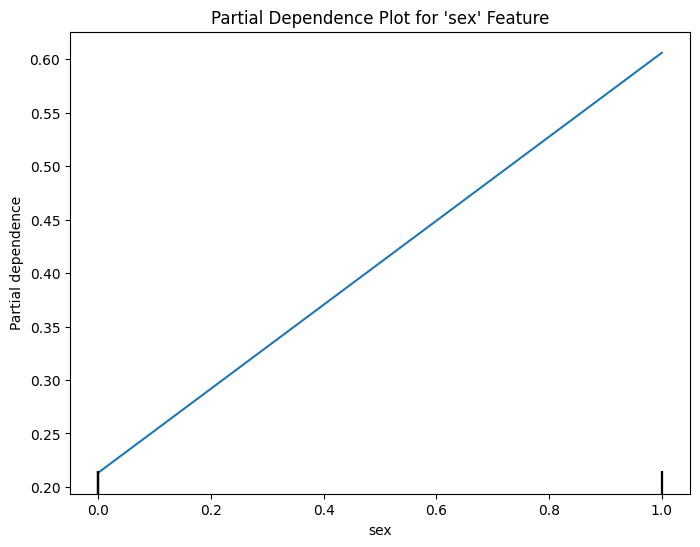

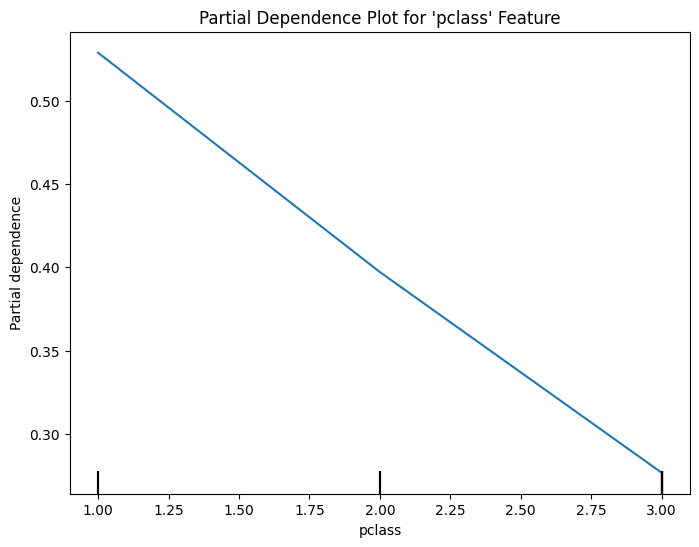

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(best_log_reg_model, titanic_X_train, features=['sex'], ax=ax)
plt.title("Partial Dependence Plot for 'sex' Feature")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(best_log_reg_model, titanic_X_train, features=['pclass'], ax=ax)
plt.title("Partial Dependence Plot for 'pclass' Feature")
plt.show()


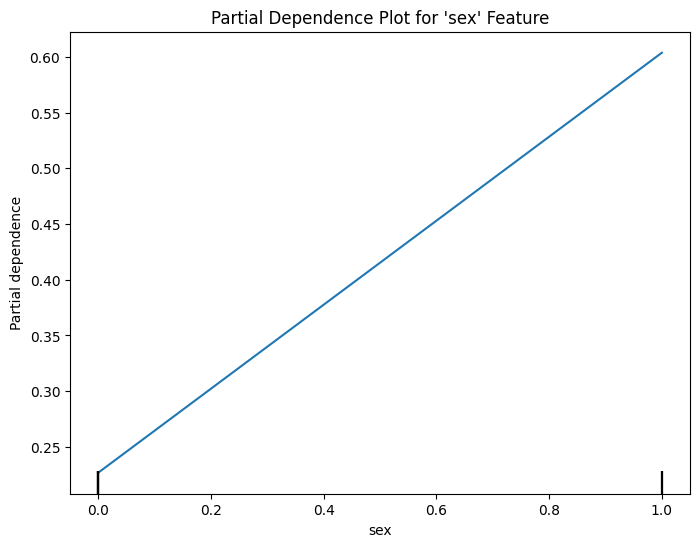

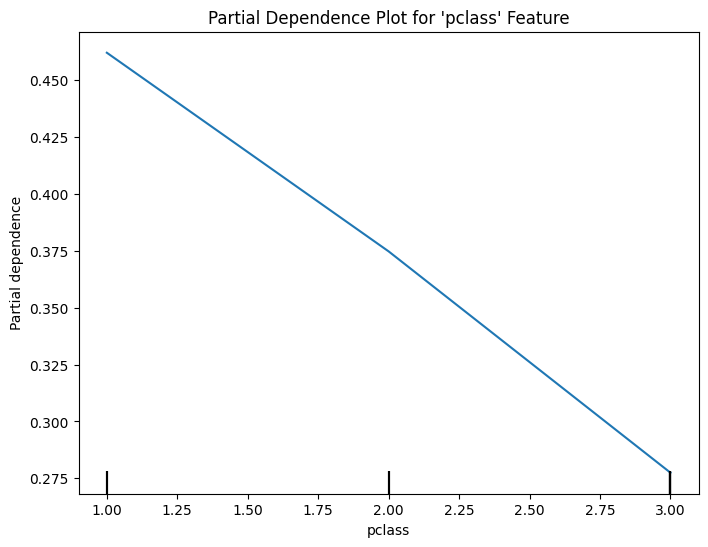

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(best_rf_model, titanic_X_train, features=['sex'], ax=ax)
plt.title("Partial Dependence Plot for 'sex' Feature")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(best_rf_model, titanic_X_train, features=['pclass'], ax=ax)
plt.title("Partial Dependence Plot for 'pclass' Feature")
plt.show()
